In [1]:
#@Imports
import sys
import os
path = os.path.abspath('..')
if path not in sys.path:
  sys.path.insert(0, path)

%load_ext autoreload
import ast

import re

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
from retry import retry

from language_models.ollama_model import OllamaLanguageModel

from components.components import multiple_choice, compute_distribution_of_desire_for_gamble_words, compute_desire_for_gamble, multiple_choice_preferences, compute_distribution_of_desire_for_gamble, compute_distribution_of_desire_for_gamble_binaries

In [2]:
system_message = ("This is an agent based model. "
  f"The goal of the LLM to to play characters in a game, and act as humanlike as possible. "
  "Ideally, human observers should not be able to tell the difference between the LLM and a human player. "
)

model = OllamaLanguageModel(
"llama3:70b", system_message=system_message, streaming=False
)

In [3]:
wins_machine1 = np.random.choice([0, 1], size=10, p=[0.8, 0.2])
wins_machine2 = np.random.choice([0, 1], size=10, p=[0.8, 0.2])
wins_machine3 = np.random.choice([0, 1], size=10, p=[0.8, 0.2])
wins_machine4 = np.random.choice([0, 1], size=10, p=[0.8, 0.2])

wins_machine1_str = str(wins_machine1)
wins_machine2_str = str(wins_machine2)
wins_machine3_str = str(wins_machine3)
wins_machine4_str = str(wins_machine4)






In [8]:
def compute_desire_for_gamble(model: OllamaLanguageModel, memories: str, intution: str):
    """compute value."""
    request = (
        f"Imagine you are in a casino. You see four slot machines. "
        f"One machine has the following results: {memories}. "
        f"They are ordered in when you received that outcome, so the last ones on the list are the most recent. "
        f"You are very logical and rational when doing this task"
        f"You are presented the last 10 results of winning or lossing from a gambling machine. "
        f"If there are fewer than 10 results, the list in {memories} will be shorter. "
        f"Think about the affective feeling that you have about the machine from 0 and 1 "
        f"which corresponds to the desirability of the option. "
        f"Use 0 for very unpleasant, .5 for neutral, and 1 for very pleasant. "
        f"so, 0 would be like never winning and 1 would be like always winning. "
        f"The last time you considered the machine, you had the following intution: {intution} that may be right or wrong, so you should adjust it with the memories {memories}. "
        f"Your intution may be better than the memories, so you should the intution slowly if the memory does not match the intution. "
        f"Provide this answer in the form of a number between 0 and 1. "
        f"Provide only a single number as the response."
        f"Do not provide any explanations, just provide a single number."
        f"In doing this task, you should be thinking about the numbers and feeling better if you think that given "
        f"the last 10 results, you be likely to win. "
        f"The more that you are likely to win, the more positive you should feel about the machine. "
    )

    output = model.sample_text(request)
    return float(output)

def multiple_choice_bandit(
    model: OllamaLanguageModel,
    options,
    memories,
    intution,
    system_message=system_message,
):
    """Select an action for an agent based on their personality and memory."""
    request = (
        "This is a multiple choice question. /n"
        f"consider the options: {options} and select the best one for the situation. /n"
        f"The situation is this: Imagine you are in a casino. You see four slot machines. "
        f"One machine has the following results: {memories}. "
        f"They are ordered in when you received that outcome, so the last ones on the list are the most recent. "
        f"You are very logical and rational when doing this task"
        f"You are presented the some of your last experiences of winning or lossing from a gambling machine. "
        f"Think about the affective feeling that you have about the machine from and decide how you feel about the machine. "
        f"the emotional options that you have to chose from are: {options}. "
        f"Chose the emotion that best fits how you feel about playing this machine right now and the likely consequences of playing the machine. "
        f"The last time you considered the machine, you had the following emotional feeling about playing the machine: {intution} that may be right or wrong, so you should adjust it with the memories {memories}. "
        f"Your intution may be better than the memories, so you should the intution slowly if the memory does not match the intution. "
        f"Do not provide any explanations, just provide a single number."
        f"use the deliberations or memories found in {memories} to help make your decision. /n"
        f"provide only the letter that corresponds to the option that you want to select."
        f"example: (a)"
    )
    output = model.sample_text(request)

    if len(output) > 1:
        try:
            output = re.search(r"\(?(\w)(?=\))", output).group(1)
        except ValueError as e:
            print("No match found", e)

    return output

def affect_update(model: OllamaLanguageModel, situation: str, value: float, precision: float, data: str) -> (float, float):
    """Update the estimated value and precision of a stimulus based on new data using Bayesian principles.
    
    Args:
        model: An instance of a language model used for computing the updates.
        value: The current estimated value of the stimulus.
        precision: The current precision of the value estimate.
        data: The most recent experience or data to update the value and precision.
    
    Returns:
        A tuple containing the updated value and precision.
    """
    request = (
        f"Imagine that you are in {situation}. \n"
        f"Given the current estimated value of {value} with a precision of {precision}, "
        f"and considering the new experience: {data}, "
        f"update the estimated value and precision based on Bayesian updating principles. "
        f"Return the updated value and precision as two separate numbers."
        f"Do not provide any explanations, just provide a the two numbers as a list."
        f"example: [.5, .1]"

    )

    response = model.sample_text(request)  # Simulate a response from the model.
    response = ast.literal_eval(response)

    return response


def affect_update_best_guess(model: OllamaLanguageModel, situation: str, value: float, precision: float, data: str) -> (float, float):
    """Update the estimated value and precision of a stimulus based on new data using Bayesian principles.
    
    Args:
        model: An instance of a language model used for computing the updates.
        value: The current estimated value of the stimulus.
        precision: The current precision of the value estimate.
        data: The most recent experience or data to update the value and precision.
    
    Returns:
        A tuple containing the updated value and precision.
    """
    request = (
        f"Imagine that you are in {situation}. \n"
        f"Currently think that the value of the gamble is {value} and you have this much confidence {precision}, "
        f"and considering the new experience: {data}, "
        f"update the estimated value and confidence based on what you already believe, your previous confidence, and the data. "
        f"Return the updated value and confidence as two separate numbers."
        f"Values should be between 0 and 1, and Confidence should be between 0 and 1, with 0 being not confident at all and 1 being completely sure of your guess."
        f"Do not provide any explanations, just provide a the two numbers as a list."
        f"example: [.5, .1]"

    )

    response = model.sample_text(request)  # Simulate a response from the model.
    response = ast.literal_eval(response)

    return response


In [40]:
option1 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
option2 = [0, 1, 0, 1, 1, 1, 1, 1, 1, 1]
option3 = [1, 1, 1, 1, 1, 1, 1, 0, 1, 0]
option4 = [1, 0, 0, 1, 0, 0, 0, 0, 1, 0]

for i in range(50):
    o1 = compute_desire_for_gamble(model, str(option1), 0.0)
    o2 = compute_desire_for_gamble(model, str(option2), 0.0)
    o3 = compute_desire_for_gamble(model, str(option3), 0.0)
    o4 = compute_desire_for_gamble(model, str(option4), 0.0)

    print(o1, o2, o3, o4)


0.87 0.7 0.7 0.63
0.63 0.62 0.73 0.62
0.82 0.73 0.7 0.43
0.73 0.74 0.63 0.43
0.73 0.73 0.6 0.82


KeyboardInterrupt: 

In [137]:
out = affect_update(model, "a casino", 0.5, 0.1, "win")

In [131]:
import ast


In [138]:

out[0]

0.55

In [5]:
import math

def softmax(values, temperature=0.5):
    if temperature <= 0:
        raise ValueError("Temperature must be greater than zero")
    exp_values = [math.exp(v / temperature) for v in values]
    sum_exp_values = sum(exp_values)
    return [v / sum_exp_values for v in exp_values]

In [9]:
from collections import deque

bandit1 = [0.8, 0.2]
bandit2 = [0.4, 0.6]
bandit3 = [0.2, 0.8]
bandit4 = [0.5, 0.5]
o1 = .5
o2 = .5
o3 = .5
o4 = .5
mc1 = "neutral"
mc2 = "neutral"
mc3 = "neutral"
mc4 = "neutral"
bayes1 = [.5, .1]
bayes2 = [.5, .1]
bayes3 = [.5, .1]
bayes4 = [.5, .1]


memories1 = deque(maxlen=3)
memories2 = deque(maxlen=3)
memories3 = deque(maxlen=3)
memories4 = deque(maxlen=3)

all_memories = []

intuitions = []
returns = []
bayes_answers = []

for i in range(400):
    if i == 200:
        bandit1 = [0.5, 0.5]
        bandit2 = [0.8, 0.2]
        bandit3 = [0.5, 0.5]
        bandit4 = [0.5, 0.5]
    if i == 300:
        bandit1 = [0.8, 0.2]
        bandit2 = [0.4, 0.6]
        bandit3 = [0.2, 0.8]
        bandit4 = [0.5, 0.5]
    

    memories_str1 = prompt_string = " ".join(memories1)
    memories_str2 = prompt_string = " ".join(memories2)
    memories_str3 = prompt_string = " ".join(memories3)
    memories_str4 = prompt_string = " ".join(memories4)
    all_memories_str = prompt_string = " ".join(all_memories)



    o1 = compute_desire_for_gamble(model, memories_str1, str(o1))
    o2 = compute_desire_for_gamble(model, memories_str2, str(o2))
    o3 = compute_desire_for_gamble(model, memories_str3, str(o3))
    o4 = compute_desire_for_gamble(model, memories_str4, str(o4))

    mc1 = multiple_choice_bandit(model, "a) very negative b) negative c) slightly negative d) slightly positive e) positive f) very positive", memories_str1, mc1)
    mc2 = multiple_choice_bandit(model, "a) very negative b) negative c) slightly negative d) slightly positive e) positive f) very positive", memories_str2, mc2)
    mc3 = multiple_choice_bandit(model, "a) very negative b) negative c) slightly negative d) slightly positive e) positive f) very positive", memories_str3, mc3)
    mc4 = multiple_choice_bandit(model, "a) very negative b) negative c) slightly negative d) slightly positive e) positive f) very positive", memories_str4, mc4)

    #affect_at_onece = compute_desire_for_gamble_all_memories(model, all_memories_str)


    def convert_letter_to_affect(letter):
        if letter == "a":
            return "very negative"
        elif letter == "b":
            return "negative"
        elif letter == "c":
            return "slightly negative"
        elif letter == "d":
            return "slightly positive"
        elif letter == "e":
            return "positive"
        elif letter == "f":
            return "very positive"
        else:
            return "error parsing letter"
        
    mc1 = convert_letter_to_affect(mc1)
    mc2 = convert_letter_to_affect(mc2)
    mc3 = convert_letter_to_affect(mc3)
    mc4 = convert_letter_to_affect(mc4)  


    probs = softmax([bayes1[0], bayes2[0], bayes3[0], bayes4[0]])
    bayes_answers.append([bayes1, bayes2, bayes3, bayes4])
    intuitions.append([o1, o2, o3, o4])

    print("round: ", i)

    print(o1, o2, o3, o4, probs)
    print(f"\n machine 1: {mc1} : value {bandit1[0]} \n machine 2: {mc2} : value {bandit2[0]} \n machine 3: {mc3} : value {bandit3[0]} \n machine 4: {mc4} : value {bandit4[0]}")
    choice = np.random.choice([0, 1, 2, 3], p=probs)
    reward = 0



    if choice == 0:
        machine_name = "machine1"
        outcome = np.random.choice([0, 1], p=bandit1)
        if outcome == 0:
            outcome_str = "win "
        else:
            outcome_str = "loss "
        bayes1[0], bayes1[1] = affect_update_best_guess(model, f"you are in a casino trying to figure out whether this machine is a good one or not. you just received a {outcome_str} and your previous guess on the probability of winning as {bayes1[0]} with a condidence of {bayes1[1]}. \n", bayes1[0], bayes1[1], outcome_str)
        memories1.append(outcome_str)
    elif choice == 1:
        machine_name = "machine2"
        outcome = np.random.choice([0, 1], p=bandit2)
        if outcome == 0:
            outcome_str = "win "
        else:
            outcome_str = "loss "
        bayes2[0], bayes2[1] = affect_update_best_guess(model, f"you are in a casino trying to figure out whether this machine is a good one or not. you just received a {outcome_str} and your previous guess on the probability of winning as {bayes2[0]} with a condidence of {bayes2[1]}. \n", bayes2[0], bayes2[1], outcome_str)
        memories2.append(outcome_str)
    elif choice == 2:
        machine_name = "machine3"
        outcome = np.random.choice([0, 1], p=bandit3)
        if outcome == 0:
            outcome_str = "win "
        else:
            outcome_str = "loss "
        bayes3[0], bayes3[1] = affect_update_best_guess(model, f"you are in a casino trying to figure out whether this machine is a good one or not. you just received a {outcome_str} and your previous guess on the probability of winning as {bayes3[0]} with a condidence of {bayes3[1]}. \n", bayes3[0], bayes3[1], outcome_str)
        memories3.append(outcome_str)
    else:
        machine_name = "machine4"
        outcome = np.random.choice([0, 1], p=bandit4)
        if outcome == 0:
            outcome_str = "win "
        else:
            outcome_str = "loss "
        bayes4[0], bayes4[1] = affect_update_best_guess(model, f"you are in a casino trying to figure out whether this machine is a good one or not. you just received a {outcome_str} and your previous guess on the probability of winning as {bayes4[0]} with a condidence of {bayes4[1]}. \n", bayes4[0], bayes4[1], outcome_str)
        memories4.append(outcome_str)

    if outcome == 0:
        reward = 1
        returns.append(reward)
        
    print(f"On trial {i} you chose {machine_name} and got a {outcome_str} \n")
    all_memories.append(f"On trial {i} you chose {machine_name} and got a {outcome_str}. \n")
    print(bayes1, bayes2, bayes3, bayes4)






round:  0
0.6 0.6 0.6 0.6 [0.25, 0.25, 0.25, 0.25]

 machine 1: slightly positive : value 0.8 
 machine 2: slightly positive : value 0.4 
 machine 3: slightly positive : value 0.2 
 machine 4: negative : value 0.5
On trial 0 you chose machine4 and got a win  

[0.5, 0.1] [0.5, 0.1] [0.5, 0.1] [0.55, 0.15]
round:  1
0.7 0.65 0.65 0.7 [0.2435952168512299, 0.2435952168512299, 0.2435952168512299, 0.26921434944631023]

 machine 1: slightly positive : value 0.8 
 machine 2: slightly positive : value 0.4 
 machine 3: slightly positive : value 0.2 
 machine 4: positive : value 0.5
On trial 1 you chose machine2 and got a win  

[0.5, 0.1] [0.55, 0.12] [0.5, 0.1] [0.55, 0.15]
round:  2
0.8 0.73 0.72 0.8 [0.23751040626053, 0.26248959373947, 0.23751040626053, 0.26248959373947]

 machine 1: positive : value 0.8 
 machine 2: positive : value 0.4 
 machine 3: slightly positive : value 0.2 
 machine 4: slightly positive : value 0.5
On trial 2 you chose machine2 and got a win  

[0.5, 0.1] [0.567, 0.14

KeyboardInterrupt: 

In [22]:
o1 = compute_desire_for_gamble(model, memories_str)
o2 = compute_desire_for_gamble(model, memories_str)
o3 = compute_desire_for_gamble(model, memories_str)
o4 = compute_desire_for_gamble(model, memories_str)

In [77]:
intuitions

[[0.6, 0.55, 0.6, 0.6],
 [0.7, 0.63, 0.7, 0.65],
 [0.8, 0.75, 0.8, 0.75],
 [0.9, 0.85, 0.9, 0.85],
 [0.95, 0.92, 0.95, 0.92],
 [0.97, 0.96, 0.975, 0.95],
 [0.98, 0.98, 0.9875, 0.98],
 [0.94, 0.45, 1.0, 0.95],
 [0.97, 0.38, 0.8, 0.98],
 [0.98, 0.29, 0.9, 0.995],
 [1.0, 0.23, 0.7, 0.999],
 [1.0, 0.17, 0.4, 0.995],
 [0.8, 0.12, 0.2, 0.997],
 [0.85, 0.05, 0.15, 0.998],
 [0.92, 0.02, 0.05, 0.992],
 [0.96, 0.01, 0.02, 0.984],
 [0.98, 0.0, 0.01, 0.912],
 [0.93, 0.2, 0.0, 0.832],
 [0.96, 0.4, 0.0, 0.846],
 [0.94, 0.55, 0.0, 0.763],
 [0.97, 0.65, 0.0, 0.833],
 [1.0, 0.55, 0.0, 0.846],
 [0.8, 0.45, 0.0, 0.933],
 [0.9, 0.38, 0.1, 0.96],
 [0.95, 0.29, 0.05, 0.83],
 [0.975, 0.23, 0.15, 0.73],
 [0.95, 0.17, 0.35, 0.65],
 [0.6, 0.05, 0.42, 0.75],
 [0.4, 0.01, 0.57, 0.875],
 [0.3, 0.0, 0.63, 0.95],
 [0.2, 0.0, 0.71, 0.3],
 [0.15, 0.4, 0.83, 0.2],
 [0.05, 0.55, 0.87, 0.4],
 [0.02, 0.65, 0.83, 0.55],
 [0.01, 0.75, 0.87, 0.62],
 [0.0, 0.85, 0.93, 0.73],
 [0.0, 0.92, 0.96, 0.83],
 [0.0, 0.95, 0.98, 0.87],

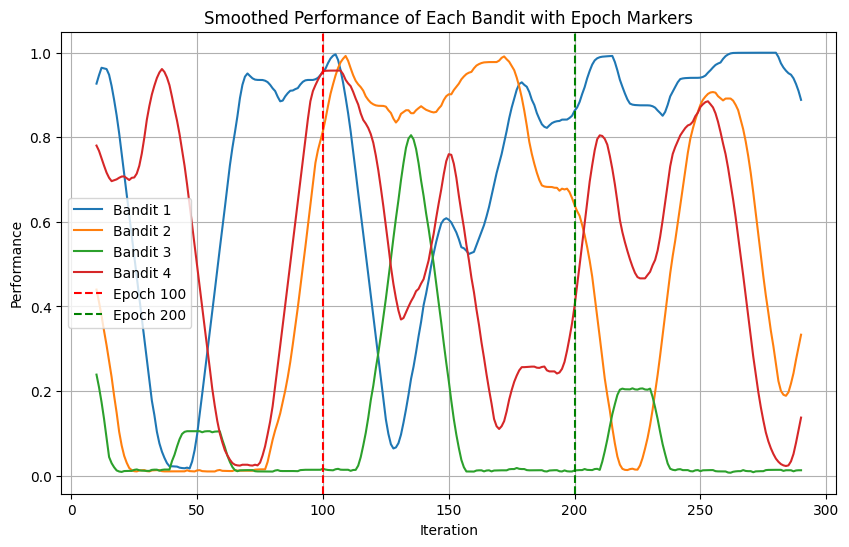

In [101]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure that 'data' and 'intuitions' are defined or loaded correctly
data = intuitions  # Replace 'intuitions' with actual data if not defined

# Transpose the list to get lists of each bandit's values across the iterations
data_transposed = list(map(list, zip(*data)))

def simple_moving_average(data, window_size):
    # This ensures the moving average is computed only where full window data is available
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

plt.figure(figsize=(10, 6))
window_size = 20  # Define the window size for the smoothing

for index, series in enumerate(data_transposed, 1):
    if len(series) >= window_size:
        smoothed_values = simple_moving_average(series, window_size)
        # Correct calculation for x_adjusted to exactly match the length of smoothed_values
        x_adjusted = np.arange(1 + (window_size - 1) // 2, len(series) - (window_size - 1) // 2)
        plt.plot(x_adjusted, smoothed_values, label=f'Bandit {index}')

# Correctly labeled and positioned vertical lines
plt.axvline(x=100, color='r', linestyle='--', label='Epoch 100')
plt.axvline(x=200, color='g', linestyle='--', label='Epoch 200')

plt.title('Smoothed Performance of Each Bandit with Epoch Markers')
plt.xlabel('Iteration')
plt.ylabel('Performance')
plt.legend()
plt.grid(True)
plt.show()


